In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint

from py_analyze_tools.sklearn import BasisFunctionConfiguration, ReaDDyElasticNetEstimator, CV, get_dense_params

from scipy.integrate import odeint
import numpy as np
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from pathos.multiprocessing import Pool
from sklearn.model_selection import KFold
import itertools

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:]
traj.update()

traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.update()

bfc = BasisFunctionConfiguration(n_species=4)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

max counts = 6000.0, min nonzero counts = 1.0
max counts = 4202.0, min nonzero counts = 825.0


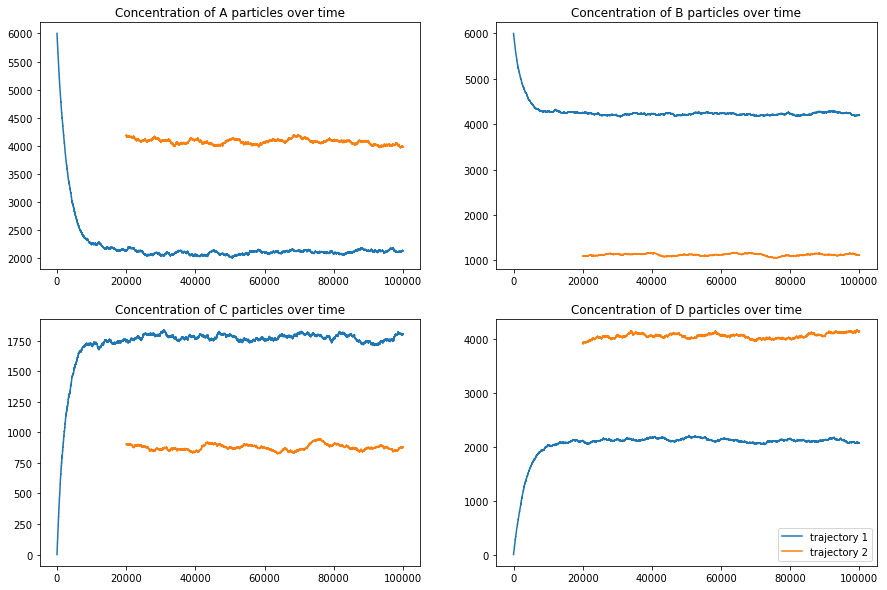

In [3]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps), traj.counts[:, i], label="trajectory 1")
    axes[i].plot(np.arange(0, traj2.n_time_steps)+20000, traj2.counts[:, i], label="trajectory 2")
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

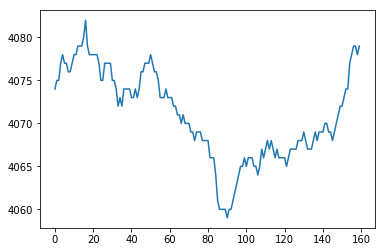

In [4]:
plt.plot(np.arange(0, traj2.n_time_steps//500), traj2.counts[10000:10000+traj2.n_time_steps//500, 0])

# cross validation within trajectory 2 using k-fold

In [ ]:
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=5)
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
coeffs = get_dense_params(traj2, bfc, scale, n_jobs=8, n_initial_values=64)

In [ ]:
print("estimated coefficients:")

mean, std = np.mean(np.array(coeffs), axis=0), np.std(np.array(coeffs), axis=0)
print("mean=%s" % mean)
print("std=%s" % std)

In [ ]:
traj_tmp = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_tmp.counts = traj2.counts[20000:30000]
traj_tmp.update()

mean = np.array([  1.83750827e-05, 1.65500856e-07, 5.46281945e-08, 1.42029075e-05, 9.25337325e-02, 5.00634680e-02, 3.13310466e-04, 9.54048258e-02, 1.47596956e-01])
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
cv = CV(traj2, bfc, scale, alphas, l1_ratios, 50, mean)
cv.fit()

In [ ]:
for r in cv.result:
    print("alpha={}, l1_ratio={} -> scores={}".format(r['alpha'], r['l1_ratio'], r['scores']))

In [ ]:
# blab = best_alpha, best_l1 = 0, 0
best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']

In [ ]:
best_alpha, best_l1, best_score = 800, 1.0, -1
mean = np.array([1.83750827e-05, 1.65500856e-07, 5.46281945e-08, 1.42029075e-05, 9.25337325e-02, 
                 5.00634680e-02, 3.13310466e-04, 9.54048258e-02, 1.47596956e-01])
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)

In [ ]:
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

In [ ]:
traj_equilibrated = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_equilibrated.counts = traj_equilibrated.counts[20000:]
traj_equilibrated.update()
    
if False:
    # now estimate the coefficients with these parameters on equlibrated trajectory
    coefficients = []
    initial_values = [np.random.random(bfc.n_basis_functions) for _ in range(5)]
    for init_xi in initial_values:
        best_estimator = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, 
                                                   alpha=best_alpha, l1_ratio=best_l1, init_xi=init_xi)
        best_estimator.fit(range(0, traj_equilibrated.n_time_steps))
        coefficients.append((init_xi, best_estimator.coefficients_))
else:
    # estimate by the init xi used in the cross validation
    est = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, alpha=.0, l1_ratio=best_l1, init_xi=mean)
    est.fit(range(0, traj_equilibrated.n_time_steps))
    coefficients = [(mean, est.coefficients_)]

In [ ]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for _, coeffs in coefficients:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(0, len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## learn from equilibrium with right initial conditions

In [ ]:
right_rates = np.array([1.96008738e-06,0,0,0,9.94587054e-03,0,0,1.00520362e-02,9.84303477e-03])

In [ ]:
traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.update()

alphas = np.linspace(0, 1000, num=16)
l1_ratios = np.linspace(0, 1, num=1) + 1
print("looking in a (alphas) x (l1_ratios) = %s x %s grid with alpha in [%s, %s] and l1_ratios in [%s, %s]" % (len(alphas), len(l1_ratios), alphas[0], alphas[-1], l1_ratios[0], l1_ratios[-1]))
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
cv = CV(traj2, bfc, scale, alphas, l1_ratios, 50, right_rates)
cv.fit()

In [ ]:
best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

In [ ]:
best_alpha, l1_ratio = 800, 1.0

In [ ]:
traj_equilibrated = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_equilibrated.counts = traj_equilibrated.counts[20000:]
traj_equilibrated.update()
est = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates)
est.fit(range(0, traj_equilibrated.n_time_steps))
coefficients = est.coefficients_

In [ ]:
print(coefficients)

In [ ]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
xs = np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], xs))
for i in range(full_traj.n_species):
    axes[i].plot(xs, full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(xs, num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## learn from equilibrium with the right set of basis functions

In [ ]:
traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.update()

bfc = BasisFunctionConfiguration(n_species=4)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
#bfc.add_fusion(0, 2, 3)  # A + C -> D
#bfc.add_fusion(0, 3, 2)  # A + D -> C
#bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
#bfc.add_fission(0, 1, 2) # A -> B + C
#bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

In [ ]:
right_rates = np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
cv = CV(traj2, bfc, scale, alphas, l1_ratios, 50, right_rates)
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

In [ ]:
traj_equilibrated = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_equilibrated.counts = traj_equilibrated.counts[20000:]
traj_equilibrated.update()
est = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, alpha=.0, l1_ratio=best_l1, init_xi=right_rates)
est.fit(range(0, traj_equilibrated.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

In [ ]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
num_solns[0] = num_solns[0][20000:]
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(20000, 20000+len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## use smaller timestep (tile counts)

In [37]:
traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.counts = traj2.counts.repeat(10, axis=0)
traj2.time_step = traj2.time_step / 10.
traj2.update()

bfc = BasisFunctionConfiguration(n_species=4)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)

max counts = 4202.0, min nonzero counts = 825.0


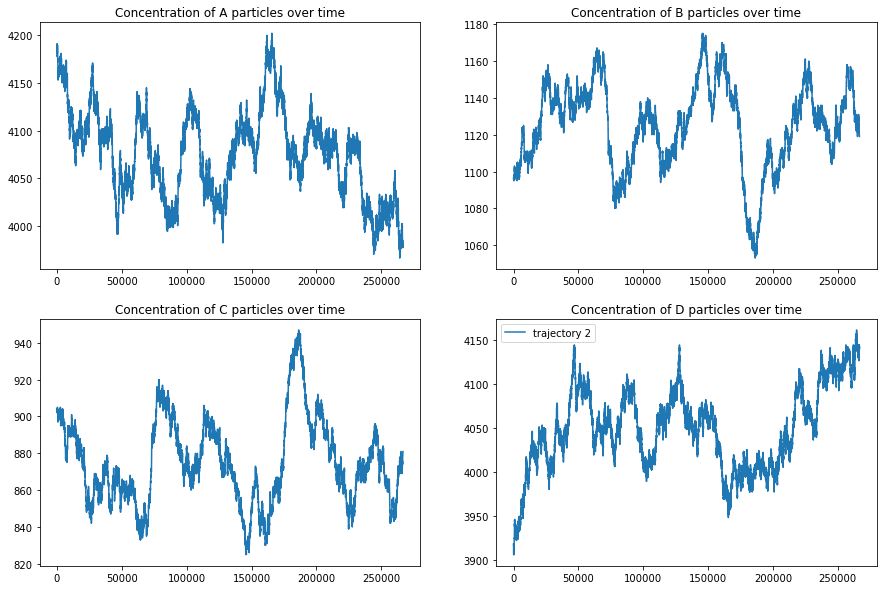

In [38]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj2.n_species):
    axes[i].plot(traj2.counts[:, i][::3], label="trajectory 2")
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

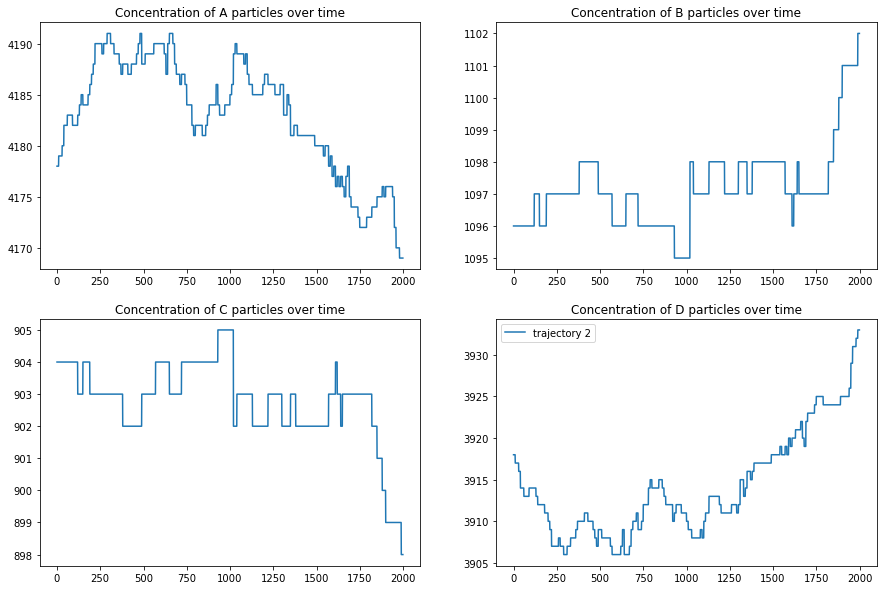

In [39]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj2.n_species):
    axes[i].plot(traj2.counts[:, i][:20000//10], label="trajectory 2")
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

In [40]:
traj2.counts = traj2.counts[:20000]
traj2.update()

right_rates = np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])
alphas = np.linspace(130, 150, num=16)
l1_ratios = np.linspace(0, 1, num=5)
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
cv = CV(traj2, bfc, scale, alphas, l1_ratios, 10, right_rates, mode='k_fold', verbose=False)
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if r['scores'] and len(r['scores']) > 0 and np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

max counts = 4191.0, min nonzero counts = 877.0


best alpha=132.666666667, best l1_ratio=0.25 with score=-14596.6727531


In [41]:
traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.counts = traj2.counts.repeat(10, axis=0)
traj2.time_step = traj2.time_step / 10.
traj2.update()

max counts = 4202.0, min nonzero counts = 825.0


In [42]:
# scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
# right_rates = np.array([0]*bfc.n_basis_functions)
print("initial xi: %s" % right_rates)
est = ReaDDyElasticNetEstimator(traj2, bfc, scale, 
                                alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates, 
                                verbose=True, approx_jac=False, method='L-BFGS-B', options={'ftol': 1e-12})
est.fit(range(0, traj2.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

initial xi: [  1.96008738e-06   9.94587054e-03   1.00520362e-02   9.84303477e-03]
optimization problem did exit successfully (alpha=132.666666667, lambda=0.25)!
status 0: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
22 / 15000 iterations
coefficients=[  0.00000000e+00   2.63283833e-05   6.74631349e-05   1.19722114e-13]


max counts = 9000.0, min nonzero counts = 1.0


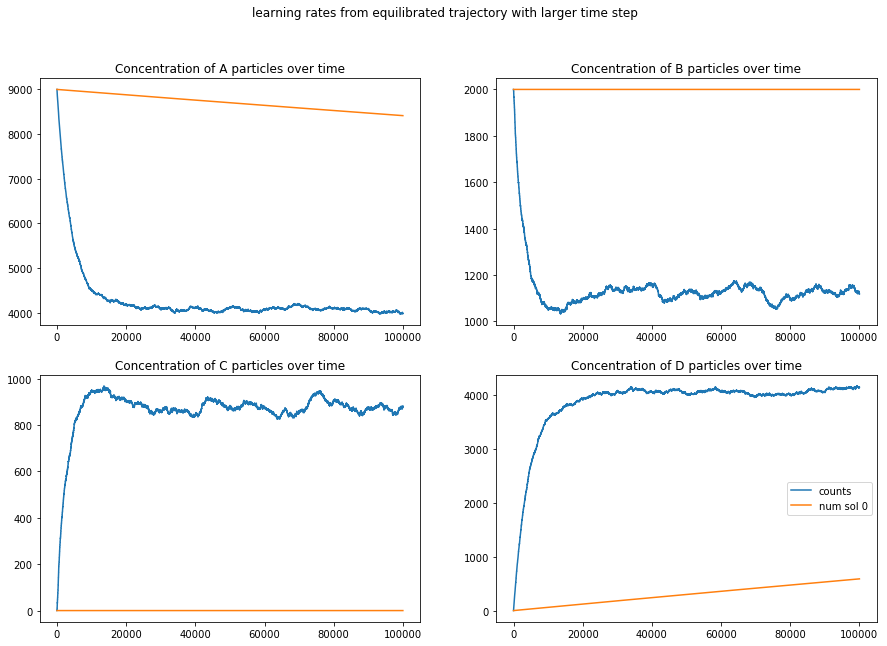

In [57]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
offset = 0
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[offset], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
num_solns[0] = num_solns[0][offset:]
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(offset, offset+len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## more ambiguity

In [ ]:
traj3 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj3.counts = traj3.counts[20000:]
traj3.counts = traj3.counts.repeat(10, axis=0)
traj3.time_step = traj3.time_step / 10.
traj3.update()

bfc = BasisFunctionConfiguration(n_species=traj3.n_species)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

In [ ]:
old_counts = np.copy(traj3.counts)

traj3.counts = traj3.counts[:20000]
traj3.update()

right_rates = np.array([1.96008738e-06,0,0,0,9.94587054e-03,0,0,1.00520362e-02,9.84303477e-03])
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj3.n_species * traj3.n_time_steps)
cv = CV(traj3, bfc, scale, alphas, l1_ratios, 10, right_rates, mode='k_fold')
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

traj3.counts = old_counts
traj3.update()

In [ ]:
est = ReaDDyElasticNetEstimator(traj3, bfc, scale, 
                                alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates, verbose=True)
est.fit(range(0, traj3.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

In [ ]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(0, len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## even more ambiguity and wrong initial conditions

In [ ]:
traj3 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj3.counts = traj3.counts[20000:]
traj3.counts = traj3.counts.repeat(10, axis=0)
traj3.time_step = traj3.time_step / 10.
traj3.update()

bfc = BasisFunctionConfiguration(n_species=traj3.n_species)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

old_counts = np.copy(traj3.counts)

traj3.counts = traj3.counts[:20000]
traj3.update()

right_rates = np.array([1e-3]*bfc.n_basis_functions)
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj3.n_species * traj3.n_time_steps)
cv = CV(traj3, bfc, scale, alphas, l1_ratios, 10, right_rates, mode='k_fold')
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

traj3.counts = old_counts
traj3.update()

est = ReaDDyElasticNetEstimator(traj3, bfc, scale, 
                                alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates, verbose=True)
est.fit(range(0, traj3.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

In [ ]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(0, len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## maybe the derivative isn't right because it only does finite differences

## fit dense solution by least squares w sparse matrices and coupling conditions

In [11]:
from scipy.optimize.optimize import approx_fprime as fprime_helper
import analyze_tools.opt as opt

In [12]:
alpha = 140
l1_ratio = .5
large_theta = np.array([f(traj2.counts) for f in bfc.functions])
large_theta = np.ascontiguousarray(np.transpose(large_theta, axes=(1, 0, 2)))
expected = traj2.dcounts_dt
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
f = lambda x: opt.elastic_net_objective_fun(x, alpha, l1_ratio, large_theta, expected, scale)
fprime = lambda x: fprime_helper(x, f, 1e-8)
fprime2 = lambda x: opt.elastic_net_objective_fun_jac(x, alpha, l1_ratio, large_theta, expected, scale)

In [13]:
print(fprime(np.array([1, 1, 1, 1])))
print(fprime2(np.array([1, 1, 1, 1])))

[  1.57713503e+13  -5.88994141e+09   3.54345703e+09  -5.91923828e+09]
[  1.57730689e+13  -3.00706182e+09   4.67187531e+09  -4.63974520e+09]


In [14]:
xa = np.linspace(0, .5, num=200)
y = np.array([fprime(np.array([x, 1e-3, 1e-3, 1e-3])) for x in xa])

In [15]:
y2 = np.array([fprime2(np.array([x, 1e-3, 1e-3, 1e-3])) for x in xa])

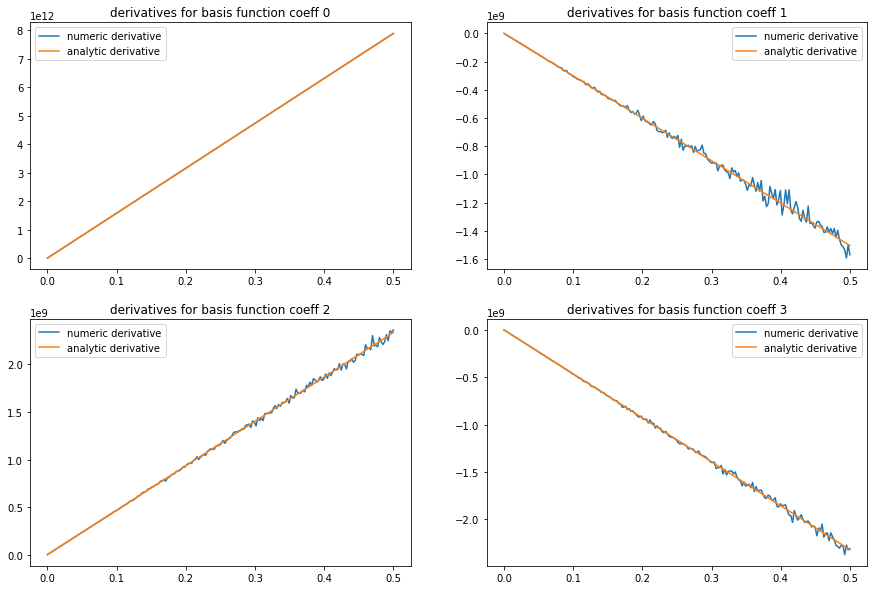

In [19]:
from itertools import chain
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = list(chain(*axes))

for rate in range(bfc.n_basis_functions):
    axes[rate].plot(xa, y[:,rate], label="numeric derivative")
    axes[rate].plot(xa, y2[:, rate], label="analytic derivative")
    axes[rate].set_title("derivatives for basis function coeff %s" % rate)
    axes[rate].legend()

plt.legend()
plt.show()

In [33]:
xa = np.linspace(0, 1e-6, num=20)
f = lambda x: opt.elastic_net_objective_fun(x, alpha, l1_ratio, large_theta, expected, scale)
r = max(xa)/2
y31 = np.array([f(np.array([1.96008738e-06-r+x,9.94587054e-03,1.00520362e-02,9.84303477e-03])) for x in xa])
y32 = np.array([f(np.array([1.96008738e-06,9.94587054e-03-r+x,1.00520362e-02,9.84303477e-03])) for x in xa])
y33 = np.array([f(np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02-r+x,9.84303477e-03])) for x in xa])
y34 = np.array([f(np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03-r+x])) for x in xa])

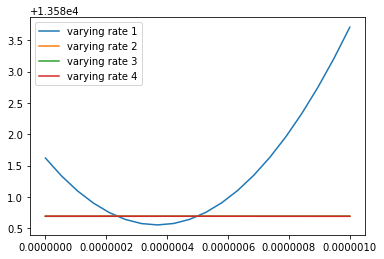

In [34]:
from itertools import chain

plt.plot(xa, y31, label="varying rate 1")
plt.plot(xa, y32, label="varying rate 2")
plt.plot(xa, y33, label="varying rate 3")
plt.plot(xa, y34, label="varying rate 4")

plt.legend()
plt.show()

In [35]:
opt.score(np.array([0.00000000e+00,2.53069627e-05,8.35795089e-05,1.64304313e-05]), large_theta, expected)

294788.7160268952

In [36]:
opt.score(np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03]), large_theta, expected)

294794.98512588476

In [43]:
opt.score(np.array([0.00000000e+00, 2.63283833e-05, 6.74631349e-05, 1.19722114e-13]), large_theta, expected)

294788.71648975153

In [49]:
f = lambda x: opt.elastic_net_objective_fun(x, 0, best_l1, large_theta, expected, scale)
print("wrong 1: %s " % f(np.array([0.00000000e+00,2.53069627e-05,8.35795089e-05,1.64304313e-05])))
print("wrong 2: %s" % f(np.array([0.00000000e+00, 2.63283833e-05, 6.74631349e-05, 1.19722114e-13])))

wrong 1: 543127.4193549092 
wrong 2: 543127.4210604695


In [50]:
print("correct: %s" % f(np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])))

correct: 543150.5203460664


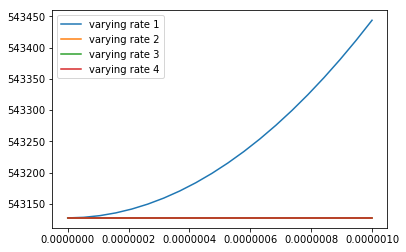

In [53]:
xa = np.linspace(0, 1e-6, num=20)
f = lambda x: opt.elastic_net_objective_fun(x, alpha, l1_ratio, large_theta, expected, scale)
r = max(xa)/2
y31 = np.array([f(np.array([0.00000000e+00+x,2.53069627e-05,8.35795089e-05,1.64304313e-05])) for x in xa])
y32 = np.array([f(np.array([0.00000000e+00,2.53069627e-05-r+x,8.35795089e-05,1.64304313e-05])) for x in xa])
y33 = np.array([f(np.array([0.00000000e+00,2.53069627e-05,8.35795089e-05-r+x,1.64304313e-05])) for x in xa])
y34 = np.array([f(np.array([0.00000000e+00,2.53069627e-05,8.35795089e-05,1.64304313e-05-r+x])) for x in xa])

plt.plot(xa, y31, label="varying rate 1")
plt.plot(xa, y32, label="varying rate 2")
plt.plot(xa, y33, label="varying rate 3")
plt.plot(xa, y34, label="varying rate 4")

plt.legend()
plt.show()